In [1]:
# Импорт необходимых библиотек для создания модели и обработки данных
# Здесь мы загружаем основные компоненты для построения модели сегментации, которая может
# эффективно обрабатывать спутниковые изображения для выявления зон наводнений.

# Keras Model: Базовый класс для построения модели, с его помощью мы будем
# определять и компилировать нашу архитектуру сверточной нейронной сети.
from tensorflow.keras.models import Model

# Импорт слоев из Keras, таких как Conv2D, MaxPooling2D и других,
# позволяет строить глубокую сверточную сеть (CNN) для анализа изображений.
# Слои MaxPooling и Conv2D помогают извлекать признаки на разных уровнях,
# что важно для точного распознавания участков с водой.
from tensorflow.keras.layers import Input, Conv2DTranspose, concatenate, Activation, MaxPooling2D, Conv2D, BatchNormalization

# Оптимизатор Adam выбран для быстрой и стабильной сходимости модели при обучении.
# Он помогает корректировать веса в сети, чтобы минимизировать ошибку сегментации.
from tensorflow.keras.optimizers import Adam

# Утилиты Keras, такие как преобразование классов в категориальный формат,
# полезны для работы с метками масок.
from tensorflow.keras import utils

# Matplotlib и Seaborn: эти библиотеки нужны для визуализации результатов сегментации,
# что важно для контроля и анализа качества модели на разных этапах обучения.
import matplotlib.pyplot as plt
import seaborn as sns

# PIL и gdal: инструменты для работы с изображениями и геоданными.
# Эти библиотеки позволяют корректно загружать и обрабатывать спутниковые снимки,
# что особенно важно для задач сегментации в области дистанционного зондирования.
from PIL import Image

# Numpy: критически важен для работы с массивами данных (изображениями), так как
# изображения представляют собой многомерные массивы пиксельных значений.
import numpy as np


In [2]:
# Загрузка тренировочного датасета
# Датасет скачивается из облачного хранилища, что позволяет быстро получить доступ к данным.
# Данные содержат спутниковые снимки и маски наводнений, которые модель будет учиться сегментировать.
gdown.download('https://lodmedia.hb.bizmrg.com/case_files/1166565/train_dataset_skoltech_train.zip', None, quiet=True)
!unzip -q '/content/train_dataset_skoltech_train.zip' -d /content/

In [4]:
# Создание директорий для хранения данных
# Структурируем данные для удобного доступа в процессе обучения и валидации.
# Папки для оригинальных изображений и масок позволяют отделить тренировочные данные
# от валидационных, что необходимо для объективной оценки качества модели.
os.mkdir('/content/train/orig/')
os.mkdir('/content/train/segm/')
os.mkdir('/content/val/orig/')
os.mkdir('/content/val/segm/')

# Определение путей к изображениям и маскам
# Эти пути будут использоваться для загрузки данных при подготовке к обучению.
pathi = '/content/train/images/'
pathm = '/content/train/masks/'
pathto = '/content/train/orig/'
pathts = '/content/train/segm/'
pathvo = '/content/val/orig/'
pathvs = '/content/val/segm/'

# Установка размеров изображений
# Указание стандартных размеров для изображений упрощает их обработку и
# гарантирует, что они будут совместимы с входом модели.
xx = 512
yy = 512

In [ ]:
xx=300
yy=300

## подготовка датасета

In [ ]:
/content/train/images/1.tif

In [8]:
imag = Image.open('/content/train/images/1.tif')

ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 10


UnidentifiedImageError: cannot identify image file '/content/train/images/1.tif'

In [6]:
filename= '1' #'.tif'
imag = Image.open(pathi+filename+'.tif')
mask = Image.open(pathm+filename+'.tif')
width, height = imag.size
x=2300
y=0
for numx in range(0,6000,xx):
   for numy in range(0,6000,xx):
      cord = (numx, numy, numx+xx, numy+yy) # лево, верх, право, низ
      new_picture = imag.crop(cord)
      new_mask = mask.crop(cord)
      new_picture.save(pathto+filename+'_'+str(numx)+'_'+str(numx)+'.tif')
      new_mask.save(pathts+filename+'_'+str(numx)+'_'+str(numx)+'.tif')


ERROR:PIL.TiffImagePlugin:More samples per pixel than can be decoded: 10


UnidentifiedImageError: cannot identify image file '/content/train/images/1.tif'

## **модель**

In [ ]:
# Глобальные параметры

IMG_WIDTH = 512               # Ширина картинки
IMG_HEIGHT = 512              # Высота картинки
CLASS_COUNT = 2               # Количество классов на изображении
TRAIN_DIRECTORY = 'train'     # Название папки с файлами обучающей выборки
VAL_DIRECTORY = 'val'         # Название папки с файлами проверочной выборки

In [ ]:
# Служебная функция загрузки выборки изображений из файлов в папке

def load_imageset(folder,   # имя папки
                  subset,   # подмножество изображений - оригинальные или сегментированные
                  title     # имя выборки
                  ):

    # Cписок для хранения изображений выборки
    image_list = []

    # Отметка текущего времени
    cur_time = time.time()

    # Для всех файлов в каталоге по указанному пути:
    for filename in sorted(os.listdir(f'{folder}/{subset}')):

        # Чтение очередной картинки и добавление ее в список изображений требуемого размера
        image_list.append(image.load_img(os.path.join(f'{folder}/{subset}', filename),
                                         target_size=(IMG_WIDTH, IMG_HEIGHT)))

    # Вывод времени загрузки картинок выборки
    print('{} выборка загружена. Время загрузки: {:.2f} с'.format(title,
                                                                  time.time() - cur_time))

    # Вывод количества элементов в выборке
    print('Количество изображений:', len(image_list))

    return image_list

In [ ]:
# Функция для просмотра изображений из набора

def show_imageset(image_list,  # выборка изображений
                  n            # количество картинок для просмотра
                  ):

    fig, axs = plt.subplots(1, n, figsize=(25, 10))       # Создание полотна из n графиков

    # Вывод в цикле n случайных изображений
    for i in range(n):
        img = random.choice(image_list)                   # Выборка случайного фото для отображения
        axs[i].axis('off')
        axs[i].imshow(img)                                # Отображение картинки

    plt.show()                                            # Отрисовка изображений

In [ ]:
# Загрузка входных изображений

train_images = load_imageset(TRAIN_DIRECTORY, 'orig', 'Обучающая')
val_images = load_imageset(VAL_DIRECTORY, 'orig', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.02 с
Количество изображений: 130
Проверочная выборка загружена. Время загрузки: 0.01 с
Количество изображений: 50


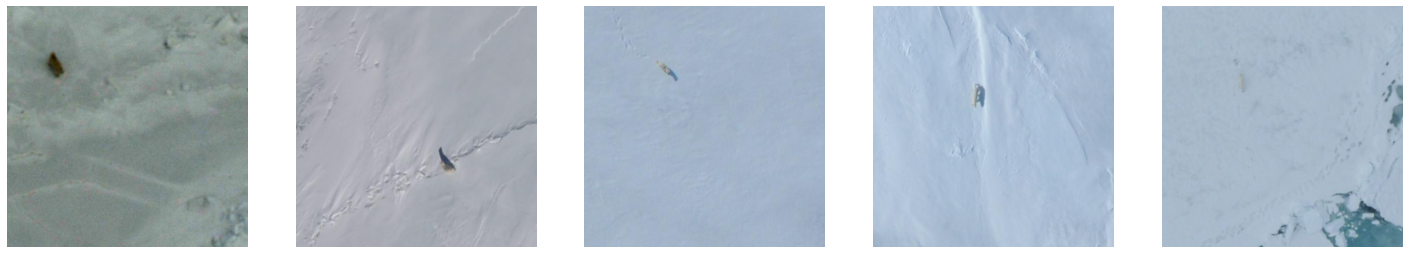

In [ ]:
# Просмотр входных изображений из обучающего набора

show_imageset(train_images, 5)

In [ ]:
# Загрузка выходных (сегментированных) изображений

train_segments = load_imageset(TRAIN_DIRECTORY, 'segm', 'Обучающая')
val_segments = load_imageset(VAL_DIRECTORY, 'segm', 'Проверочная')

Обучающая выборка загружена. Время загрузки: 0.01 с
Количество изображений: 130
Проверочная выборка загружена. Время загрузки: 0.00 с
Количество изображений: 50


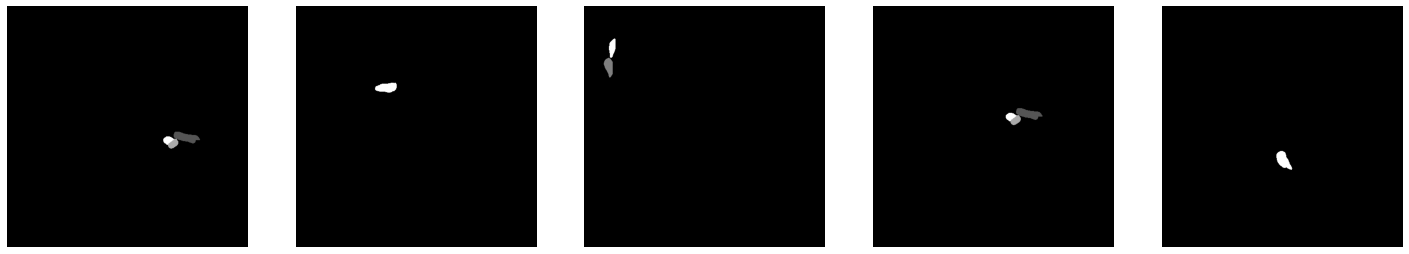

In [ ]:
# Просмотр сегментированных изображений из обучающего набора

show_imageset(train_segments, 5)

In [ ]:
# Цвета пикселов сегментированных изображений

Bears = (255, 255, 255)      # Мишка (белый)
BACKGROUND = (0, 0, 0)          # Фон (черный)

In [ ]:
CLASS_LABELS = (Bears, BACKGROUND)

In [ ]:
# Функция преобразования цветного сегментированного изображения в метки классов

def rgb_to_labels(image_list  # список цветных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for d in image_list:
        sample = np.array(d)
        # Создание пустой 1-канальной картики
        y = np.zeros((IMG_WIDTH, IMG_HEIGHT, 1), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение 3-х канальных пикселей классов и занесение метки класса
            y[np.where(np.all(sample == CLASS_LABELS[i], axis=-1))] = i

        result.append(y)

    return np.array(result)

In [ ]:
# Функция преобразования тензора меток класса в цветное сегметрированное изображение

def labels_to_rgb(image_list  # список одноканальных изображений
                 ):

    result = []

    # Для всех картинок в списке:
    for y in image_list:
        # Создание пустой цветной картики
        temp = np.zeros((IMG_WIDTH, IMG_HEIGHT, 3), dtype='uint8')

        # По всем классам:
        for i, cl in enumerate(CLASS_LABELS):
            # Нахождение пикселов класса и заполнение цветом из CLASS_LABELS[i]
            temp[np.where(np.all(y==i, axis=-1))] = CLASS_LABELS[i]

        result.append(temp)

    return np.array(result)

In [ ]:
# Формирование обучающей выборки

x_train = []                          # Cписок под обучающую выборку

for img in train_images:              # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_train.append(x)                 # Добавление элемента в x_train

x_train = np.array(x_train)           # Перевод всей выборки в numpy
print(x_train.shape)                  # Форма x_train

(130, 512, 512, 3)


In [ ]:
# Формирование проверочной выборки

x_val = []                            # Cписок под проверочную выборку

for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)                    # Форма x_train

(50, 512, 512, 3)


In [ ]:
# Преобразование сегментов в метки классов

y_train = rgb_to_labels(train_segments)
y_val = rgb_to_labels(val_segments)

print(y_train.shape)
print(y_val.shape)

(130, 512, 512, 1)
(50, 512, 512, 1)


In [ ]:
# Функция визуализации процесса сегментации изображений, модифицированная для вывода по списку индексов

def process_images(model,                       # обученная модель
                   count=1,                     # количество случайных картинок для сегментации
                   indexes=None,                # список индексов изображений в проверочной выборке
                   ):

    if indexes is None:
        # Генерация случайного списка индексов в количестве count между (0, len(x_val)
        indexes = np.random.randint(0, len(x_val), count)
    else:
        count = len(indexes)

    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 10))

    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show()

## **unet**

In [ ]:
def unet(class_count,   # количество классов
         input_shape    # форма входного изображения
         ):

    img_input = Input(input_shape)                                          # Создаем входной слой формой input_shape

    ''' Block 1 '''
    x = Conv2D(64, (3, 3), padding='same', name='block1_conv1')(img_input)  # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same', name='block1_conv2')(x)          # Добавляем Conv2D-слой с 64-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_1_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_1_out

    x = MaxPooling2D()(block_1_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 2 '''
    x = Conv2D(128, (3, 3), padding='same', name='block2_conv1')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same', name='block2_conv2')(x)         # Добавляем Conv2D-слой с 128-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_2_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_2_out

    x = MaxPooling2D()(block_2_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 3 '''
    x = Conv2D(256, (3, 3), padding='same', name='block3_conv1')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv2')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same', name='block3_conv3')(x)         # Добавляем Conv2D-слой с 256-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_3_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_3_out

    x = MaxPooling2D()(block_3_out)                                         # Добавляем слой MaxPooling2D

    ''' Block 4 '''
    x = Conv2D(512, (3, 3), padding='same', name='block4_conv1')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv2')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(512, (3, 3), padding='same', name='block4_conv3')(x)         # Добавляем Conv2D-слой с 512-нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    block_4_out = Activation('relu')(x)                                     # Добавляем слой Activation и запоминаем в переменной block_4_out
    x = block_4_out

    ''' UP 2 '''
    x = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_3_out])                                       # Объединяем текущий слой со слоем block_3_out
    x = Conv2D(256, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 256 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(256, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 3 '''
    x = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(x)     # Добавляем слой Conv2DTranspose с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_2_out])                                       # Объединяем текущий слой со слоем block_2_out
    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(128, (3, 3), padding='same')(x)                              # Добавляем слой Conv2D с 128 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    ''' UP 4 '''
    x = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(x)      # Добавляем слой Conv2DTranspose с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = concatenate([x, block_1_out])                                       # Объединяем текущий слой со слоем block_1_out
    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(64, (3, 3), padding='same')(x)                               # Добавляем слой Conv2D с 64 нейронами
    x = BatchNormalization()(x)                                             # Добавляем слой BatchNormalization
    x = Activation('relu')(x)                                               # Добавляем слой Activation

    x = Conv2D(class_count, (3, 3), activation='softmax', padding='same')(x)  # Добавляем Conv2D-Слой с softmax-активацией на class_count-нейронов

    model = Model(img_input, x)                                             # Создаем модель с входом 'img_input' и выходом 'x'

    # Компилируем модель
    model.compile(optimizer=Adam(learning_rate=1e-4),
                  loss='sparse_categorical_crossentropy',
                  metrics=['sparse_categorical_accuracy'])

    # Возвращаем сформированную модель
    return model

In [ ]:
# Создание модели и вывод сводки по архитектуре

model_unet = unet(CLASS_COUNT,
                  (IMG_WIDTH, IMG_HEIGHT, 3))

model_unet.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 512, 512, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 512, 512, 64  1792        ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_19 (BatchN  (None, 512, 512, 64  256        ['block1_conv1[0][0]']           
 ormalization)                  )                                                           

In [ ]:
# Обучение модели

history = model_unet.fit(x_train, y_train,
                         epochs=13, batch_size=4,
                         validation_data=(x_val, y_val))

Epoch 1/13
33/33 [==============================] - 36s 1s/step - loss: 0.2796 - sparse_categorical_accuracy: 0.9482 - val_loss: 0.0230 - val_sparse_categorical_accuracy: 0.9968
Epoch 2/13
33/33 [==============================] - 33s 1s/step - loss: 0.0732 - sparse_categorical_accuracy: 0.9969 - val_loss: 0.0271 - val_sparse_categorical_accuracy: 0.9968
Epoch 3/13
33/33 [==============================] - 33s 989ms/step - loss: 0.0419 - sparse_categorical_accuracy: 0.9972 - val_loss: 0.0449 - val_sparse_categorical_accuracy: 0.9968
Epoch 4/13
33/33 [==============================] - 33s 994ms/step - loss: 0.0302 - sparse_categorical_accuracy: 0.9975 - val_loss: 0.0610 - val_sparse_categorical_accuracy: 0.9968
Epoch 5/13
33/33 [==============================] - 33s 996ms/step - loss: 0.0234 - sparse_categorical_accuracy: 0.9976 - val_loss: 0.0618 - val_sparse_categorical_accuracy: 0.9968
Epoch 6/13
33/33 [==============================] - 33s 992ms/step - loss: 0.0197 - sparse_categorica

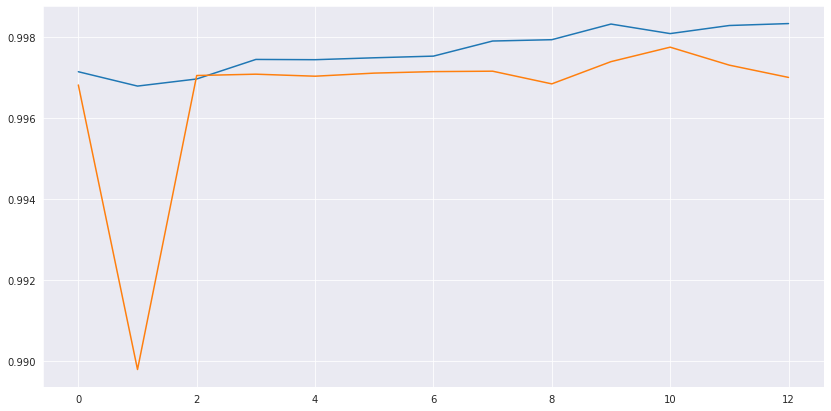

In [ ]:
# Отображение графиков обучения модели

plt.figure(figsize=(14, 7))
plt.plot(history.history['sparse_categorical_accuracy'])
plt.plot(history.history['val_sparse_categorical_accuracy'])
plt.show()

In [ ]:
process_images(model_unet, 7)

In [ ]:
# Получение массива значений функции ошибки для каждого изображения из проверочной выборки

accuracy = np.array([model_unet.evaluate(x_val[i:i+1],
                                         y_val[i:i+1],
                                         verbose=0)[1] for i in range(x_val.shape[0])])

print(accuracy)

[0.99675751 0.99776459 0.99830627 0.99858856 0.9981308  0.99718857
 0.99934006 0.99780655 0.99796677 0.99797058 0.99679184 0.99785233
 0.9982872  0.99826813 0.99816513 0.99737167 0.9991684  0.99800873
 0.99796677 0.99801636 0.99671936 0.99777985 0.99833298 0.99870682
 0.9982338  0.99737167 0.99919891 0.99785233 0.99796677 0.9980011
 0.99679947 0.99787521 0.99822617 0.99827957 0.99815369 0.99734879
 0.99905777 0.99787521 0.99796677 0.99781036]


In [ ]:
# Получение индексов самых плохих по точности сегментации изображений

print('5 худших по точности сегментации изображений')
bad = np.argsort(accuracy)[:5].tolist()

for b in bad:
    print(f'Изображение №{b} - точность: {accuracy[b]}')

5 худших по точности сегментации изображений
Изображение №20 - точность: 0.9967193603515625
Изображение №0 - точность: 0.9967575073242188
Изображение №10 - точность: 0.9967918395996094
Изображение №30 - точность: 0.9967994689941406
Изображение №5 - точность: 0.9971885681152344


In [ ]:
from itertools import product

In [ ]:
!unzip -q "0.zip" -d /content/ # подгрузим базу в ноутбук в директорию 'content/'

In [ ]:
# Создание директорий для хранения данных
# Структурируем данные для удобного доступа в процессе обучения и валидации.
# Папки для оригинальных изображений и масок позволяют отделить тренировочные данные
# от валидационных, что необходимо для объективной оценки качества модели.
os.mkdir('/content/train/orig/')
os.mkdir('/content/train/segm/')
os.mkdir('/content/val/orig/')
os.mkdir('/content/val/segm/')

# Определение путей к изображениям и маскам
# Эти пути будут использоваться для загрузки данных при подготовке к обучению.
pathi = '/content/train/images/'
pathm = '/content/train/masks/'
pathto = '/content/train/orig/'
pathts = '/content/train/segm/'
pathvo = '/content/val/orig/'
pathvs = '/content/val/segm/'

# Установка размеров изображений
# Указание стандартных размеров для изображений упрощает их обработку и
# гарантирует, что они будут совместимы с входом модели.
xx = 512
yy = 512

In [ ]:
pathi = '10'

In [ ]:
infile = '10.JPG'
chopsize = 512
img = Image.open(infile)
width, height = img.size

In [ ]:
# Save Chops of original image
for x0 in range(0, width, chopsize):
   for y0 in range(0, height, chopsize):
      box = (x0, y0,
             x0+chopsize if x0+chopsize <  width else  width - 1,
             y0+chopsize if y0+chopsize < height else height - 1)
      print('%s %s' % (infile, box))
      img.crop(box).save(pathi+'/'+'zchop.%s.x%03d.y%03d.jpg' % (infile.replace('.jpg',''), x0, y0))

10.JPG (0, 0, 512, 512)
10.JPG (0, 512, 512, 1024)
10.JPG (0, 1024, 512, 1536)
10.JPG (0, 1536, 512, 2048)
10.JPG (0, 2048, 512, 2560)
10.JPG (0, 2560, 512, 3072)
10.JPG (0, 3072, 512, 3584)
10.JPG (0, 3584, 512, 3999)
10.JPG (512, 0, 1024, 512)
10.JPG (512, 512, 1024, 1024)
10.JPG (512, 1024, 1024, 1536)
10.JPG (512, 1536, 1024, 2048)
10.JPG (512, 2048, 1024, 2560)
10.JPG (512, 2560, 1024, 3072)
10.JPG (512, 3072, 1024, 3584)
10.JPG (512, 3584, 1024, 3999)
10.JPG (1024, 0, 1536, 512)
10.JPG (1024, 512, 1536, 1024)
10.JPG (1024, 1024, 1536, 1536)
10.JPG (1024, 1536, 1536, 2048)
10.JPG (1024, 2048, 1536, 2560)
10.JPG (1024, 2560, 1536, 3072)
10.JPG (1024, 3072, 1536, 3584)
10.JPG (1024, 3584, 1536, 3999)
10.JPG (1536, 0, 2048, 512)
10.JPG (1536, 512, 2048, 1024)
10.JPG (1536, 1024, 2048, 1536)
10.JPG (1536, 1536, 2048, 2048)
10.JPG (1536, 2048, 2048, 2560)
10.JPG (1536, 2560, 2048, 3072)
10.JPG (1536, 3072, 2048, 3584)
10.JPG (1536, 3584, 2048, 3999)
10.JPG (2048, 0, 2560, 512)
10.JPG (

In [ ]:
imag = Image.open(pathb+'/'+'34.JPG')


In [ ]:
# Функция визуализации процесса сегментации изображений, модифицированная для вывода по списку индексов

def process_images(model,                       # обученная модель
                   count=1,                     # количество случайных картинок для сегментации
                   indexes=None,                # список индексов изображений в проверочной выборке
                   ):

    if indexes is None:
        # Генерация случайного списка индексов в количестве count между (0, len(x_val)
        indexes = np.random.randint(0, len(x_val), count)
    else:
        count = len(indexes)

    # Вычисление предсказания сети для картинок с отобранными индексами
    predict = np.argmax(model.predict(x_val[indexes]), axis=-1)

    # Подготовка цветов классов для отрисовки предсказания
    orig = labels_to_rgb(predict[..., None])
    fig, axs = plt.subplots(3, count, figsize=(25, 10))

    # Отрисовка результата работы модели
    for i in range(count):
        # Отображение на графике в первой линии предсказания модели
        axs[0, 0].set_title('Результат работы модели:')
        axs[0, i].imshow(orig[i])
        axs[0, i].axis('off')

        # Отображение на графике во второй линии сегментированного изображения из y_val
        axs[1, 0].set_title('Оригинальное сегментированное')
        axs[1, i].imshow(val_segments[indexes[i]])
        axs[1 ,i].axis('off')

        # Отображение на графике в третьей линии оригинального изображения
        axs[2, 0].set_title('Оригинальное изображение')
        axs[2, i].imshow(val_images[indexes[i]])
        axs[2 ,i].axis('off')

    plt.show()

In [ ]:
  # делаем предсказание
  pred = model.predict(sample[0])
  y_pred = np.argmax(pred, axis=-1)

In [ ]:
# читаем датасет
data_df = pd.read_csv("/content/train.csv")

In [ ]:
dft = pd.read_csv("test.csv", delimiter=';')
dft

In [ ]:
# Формирование проверочной выборки

x_val = []                            # Cписок под проверочную выборку

for img in val_images:                # Для всех изображений выборки:
    x = image.img_to_array(img)       # Перевод изображения в numpy-массив формы: высота x ширина x количество каналов
    x_val.append(x)                   # Добавление элемента в x_train

x_val = np.array(x_val)               # Перевод всей выборки в numpy
print(x_val.shape)                    # Форма x_train